<a href="https://www.kaggle.com/code/yannicksteph/rsna-miccai-brain-tumor-classification?scriptVersionId=130175716" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a href="https://www.kaggle.com/code/yannicksteph/rsna-miccai-brain-tumor-classification" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Work in progress 🚧

# Introduction

The RSNA-MICCAI Brain Tumor Radiogenomic Classification Contest is a multi-class classification problem, giving MRIs based on radiomic features, where the goal is to predict the presence of MGMT promoter methylation.

There are three classes: 
- LGG (low-grade glioma)
- HGG (high-grade glioma) 
- WT (hemangioblastoma)

The dataset we will be working with consists of MRI datasets provided by the Radiological Society of North America (RSNA®) and the Medical Image Computing and Computer Assisted Intervention Society (the MICCAI Society). The images are provided in DICOM format and are accompanied by a CSV file containing radiomic features extracted from the images.

Here's the competition [RSNA-MICCAI Brain Tumor Radiogenomic Classification](https://www.kaggle.com/competitions/rsna-miccai-brain-tumor-radiogenomic-classification/data?select=train_labels.csv)

# Contributors

- [David Goudard](https://www.kaggle.com/goudgoud)
- [Louis-Marie Renaud](https://www.kaggle.com/louismarierenaud)
- [Yannick Stephan](https://github.com/YanSteph)


# Dataset

The exact mpMRI scans included are:
- Fluid Attenuated Inversion Recovery (FLAIR)
    * What it is: These are images that detect brain abnormalities, such as edema and inflammatory lesions. These images are sensitive to the detection of anomalies related to inflammatory and infectious diseases of the central nervous system.
    * What it highlights: It helps to detect anomalies in the brain that might not be visible in other MRI sequences.
    * These images allow for the detection of brain abnormalities related to inflammatory and infectious diseases of the central nervous system.
- T1-weighted pre-contrast (T1w)
    * What it is: These are images that highlight soft tissues, such as muscles and nerves, and are useful for visualizing normal brain structures.
    * What it highlights: It allows the visualization of the normal brain structures and also helps in the detection of tumors and lesions.
    * These images allow for the detection of brain tumors and lesions.
- T1-weighted post-contrast (T1Gd)
    * What it is: These are images that use a contrast agent to detect vascular anomalies, such as tumors and lesions, which are more visible after contrast agent administration.
    * What it highlights: It enhances the visibility of vascular anomalies, such as tumors and lesions, making it easier to detect them.
    * These images allow for the detection of vascular anomalies, such as tumors and lesions.
- T2-weighted (T2)
    * What it is: These images detect abnormalities related to demyelination, such as multiple sclerosis, as well as brain tumors and lesions.
    * What it highlights: It helps in the detection of anomalies related to cerebrospinal fluid, such as cysts and brain tumors.
    * These images allow for the detection of anomalies related to demyelination, brain tumors, lesions, and cerebrospinal fluid.

# Necessary imports

In [55]:
# Operating System and File System
import os 

# Data Manipulation and Analysis
import numpy as np  
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt 
import seaborn as sns

# Warnings
import warnings  # For suppressing warnings

# JSON Handling
import json  # For working with JSON data

# Encoding and Decoding Binary Data
import base64  # For encoding and decoding binary data

# Interactive Widgets and Display
import ipywidgets as widgets  # For creating interactive widgets in Jupyter Notebook
from IPython.display import HTML, display  # For displaying HTML content

# Deep Learning Framework
import torch  # For working with PyTorch deep learning framework

# DICOM File Handling
import pydicom  # For reading DICOM files
from pydicom import dcmread  # For reading DICOM files

# Image Processing and Filtering
import SimpleITK as sitk  # For image filtering
from PIL import Image  # For image processing using the Python Imaging Library (PIL)

# Machine Learning and Data Splitting
from sklearn.model_selection import train_test_split  # For splitting data into training and testing sets

# Additional Libraries
!pip install pyradiomics > /dev/null  # Installing the pyradiomics library for radiomics feature extraction
import radiomics  # For extracting radiomics features from medical images

# Suppressing Warnings
warnings.filterwarnings('ignore')

# Paths

In [2]:
path_rsna_brain_tumor_classification = "../input/rsna-miccai-brain-tumor-radiogenomic-classification/"

train_path = path_rsna_brain_tumor_classification + "train/"
train_label_file = path_rsna_brain_tumor_classification + '/train_labels.csv'


path = "../input/rsna-miccai-brain-tumor-segmentation-pytorch-unet/"
dataset_path = "/kaggle/input/rsna-miccai-brain-tumor-segmentation-pytorch-unet/rsna_miccai_brain_tumor_brain_segmentation_pytorch_unet.csv"
#path + "rsna_miccai_brain_tumor_brain_segmentation_pytorch_unet.csv/"

# Reading Data

In [99]:
# Dataset of the project, explanation in next section.
dataset = pd.read_csv(train_label_file)
samp_subm = pd.read_csv(path_rsna_brain_tumor_classification + 'sample_submission.csv')

<hr>

# Dataset in the state exploration

The **"train/"** directory contains the training files for the competition. Each top-level directory represents a subject, and the **"train_labels.csv"** file contains the corresponding targets for each subject, indicating the presence of MGMT promoter methylation.

ℹ️ **Note:** However, report on main contest page, there are unexpected problems with the following three cases in the training dataset: [00109, 00123, 00709].

In [4]:
print('Samples of train folder:', len(dataset))

Samples of train folder: 585


In [5]:
dataset.head(10)

,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1
5,8,1
6,9,0
7,11,1
8,12,1
9,14,1


The "train_labels.csv" file.

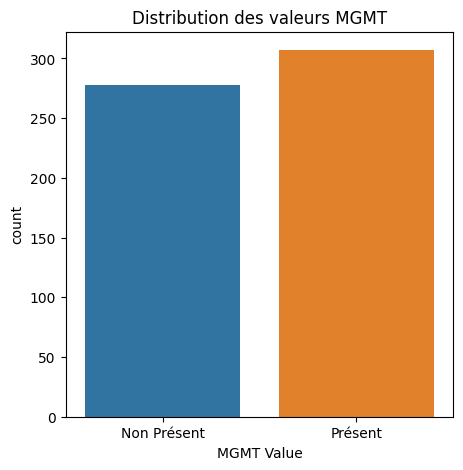

In [6]:
plt.figure(figsize=(5, 5))
sns.countplot(data=dataset, x="MGMT_value")
plt.title("Distribution of MGMT values")
plt.xlabel("MGMT Value")
plt.xticks([0, 1], ["Not Present", "Present"])
plt.show()

The **"test/"** directory contains the test files. For each subject in the test data, there is no file containing the methylation targets, so these values must be predicted. The **"sample_submission.csv"** file is an example of a correctly formatted submission file, with MGMT values of **0.5** for each subject.

Overall, the task of the competition is to predict the presence of MGMT promoter methylation for each subject in the test data.

ℹ️ **Note:** We deduce that we have to separate the sets of given train into part two part train and test for training.

In [7]:
samp_subm.head(1)

,BraTS21ID,MGMT_value
0,1,0.5


### Folders content

In [8]:
# Extract first train sample
first_folder = str(dataset.loc[0, 'BraTS21ID']).zfill(5) + "/"

# Folders content
print(
    "Folders content for all patients:", 
        json.dumps(os.listdir(train_path + first_folder), indent=4)
)

Folders content for all patients: [
    "T2w",
    "T1wCE",
    "T1w",
    "FLAIR"
]


### First patient exploration

In the first Dataset of the patient, we will explore the images contained in ['T2w', 'T1wCE', 'T1w', 'FLAIR'] of the first patient.

In [9]:
print('Number of FLAIR images:', len(os.listdir(train_path + first_folder +'FLAIR')))
print('Number of T1w images:', len(os.listdir(train_path + first_folder + 'T1w')))
print('Number of T1wCE images:', len(os.listdir(train_path + first_folder + 'T1wCE')))
print('Number of T2w images:', len(os.listdir(train_path + first_folder + 'T2w')))

Number of FLAIR images: 400
Number of T1w images: 33
Number of T1wCE images: 129
Number of T2w images: 408


ℹ️ **Summary:** 
* Exclusion of data [00109, 00123, 00709].
* Exclusion of "/test" folder. 

<hr>

# Brain segmentation with mateuszbuda brain segmentation pytorch unet

#### Why
The **"mateuszbuda_brain-segmentation-pytorch_unet"** library was utilized to obtain data for our brain dataset. This library is based on the Unet neural network architecture and specifically designed for brain segmentation from medical images.

By leveraging the capabilities of this library, accurate brain segmentation was achieved on the images within our dataset. Segmentation is a critical task in medical imaging as it enables the extraction of precise information about different regions or classes, in this case, brain structures.

The selection of the **"mateuszbuda_brain-segmentation-pytorch_unet"** library was based on its exceptional performance and user-friendly nature. It provides an efficient implementation of the Unet architecture, renowned for its success in biomedical image segmentation. Consequently, our project was able to deliver reliable and accurate results for brain segmentation.

In conclusion, the utilization of the **"mateuszbuda_brain-segmentation-pytorch_unet"** library played a pivotal role in acquiring accurate brain segmentation data for our dataset. By leveraging this library, we efficiently segmented medical images and extracted valuable information to further our project's objectives.

Source: [mateuszbuda_brain-segmentation-pytorch_unet on PyTorch Hub](https://pytorch.org/hub/mateuszbuda_brain-segmentation-pytorch_unet/)

#### Library

To achieve tumor segmentation, the U-Net for Brain MRI model will be employed.

U-Net for Brain MRI is a convolutional neural network model specifically designed for segmenting brain MRI images. It features a U-shaped architecture with branch connections, comprising four levels of blocks. Each block consists of two convolution layers with batch normalization, ReLU activation function, and an encoding part with a max pooling layer, while the decoding part utilizes up-convolution. The number of convolution filters varies across the model's levels, ranging from 32 to 256.

To utilize the model, an input brain MRI image with three channels corresponding to pre-contrast, FLAIR, and post-contrast sequences should be provided. The image should be scaled to a size of 256x256 pixels and normalized using the z-score method per volume.

The pre-trained U-Net model produces a single-channel probability map indicating anomalous regions in the input image. By applying an appropriate threshold, this probability map can be converted into a binary segmentation mask.

In summary, U-Net for Brain MRI is a pre-trained model capable of automatically segmenting abnormalities in brain MRI images. Its application extends to various medical imaging tasks, including brain tumor detection and analysis.


To perform shape analysis and extract relevant features, the **"radiomics.shape2D.RadiomicsShape2D"** class will be utilized.

Source: [Radiomics.shape2D.RadiomicsShape2D ](https://pyradiomics.readthedocs.io/en/latest/features.html#module-radiomics.shape2D)

In [45]:
# Skip brain segmentation with PyTorch UNet
skip_brain_segmentation_pytorch_unet = False

## Initialisation


Load mateuszbuda/brain-segmentation-pytorch, U-Net with batch normalization for biomedical image segmentation with pretrained weights for abnormality segmentation in brain MRI

In [12]:
# Load mateuszbuda/brain-segmentation-pytorch, U-Net with batch normalization for biomedical image segmentation with pretrained weights for abnormality segmentation in brain MRI
segmentation_model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', in_channels=3, out_channels=1, init_features=32, pretrained=True, trust_repo=False)


The repository mateuszbuda_brain-segmentation-pytorch does not belong to the list of trusted repositories and as such cannot be downloaded. Do you trust this repository and wish to add it to the trusted list of repositories (y/N)? y


Downloading: "https://github.com/mateuszbuda/brain-segmentation-pytorch/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/mateuszbuda/brain-segmentation-pytorch/releases/download/v1.0/unet-e012d006.pt" to /root/.cache/torch/hub/checkpoints/unet-e012d006.pt


In [13]:
# définit le "reader"
# Read serie of image files into a SimpleTK image
sitk_reader = sitk.ImageSeriesReader()
sitk_reader.LoadPrivateTagsOn()

## Methods definition

In [79]:
# ===============================================
# Images methods
# ===============================================

def get_processed_image(patient_id):
    """
    Retrieves and processes the images for a given patient, grouping them for segmentation.

    Args:
        patient_id (str): The ID of the patient (BraTS21ID).

    Returns:
        numpy.ndarray: A processed image composed of the different images of the patient.
    """
    # SEGMENTATION MODEL LIMITED TO 3 LAYERS
    # T2W SKIPPED

    # Paths for image sequences
    t1w_path = f'{train_path}/{str(patient_id).zfill(5)}/T1w'
    flair_path = f'{train_path}/{str(patient_id).zfill(5)}/FLAIR'
    t1wce_path = f'{train_path}/{str(patient_id).zfill(5)}/T1wCE'
    #t2w_path = f'{train_path}/{str(patient_id).zfill(5)}/T2w'

    # Retrieve image sequences
    t1w_image = sequence_filenames(t1w_path)
    flair_image = sequence_filenames(flair_path)
    t1wce_image = sequence_filenames(t1wce_path)
    #t2w_image = sequence_filenames(t2w_path)

    # Resampling
    re_sampled_flair = re_sample_image(flair_image, t1w_image)
    re_sampled_t1wce = re_sample_image(t1wce_image, t1w_image)
    #re_sampled_t2w = re_sample_image(t2w_image, t1w_image)

    # Normalization
    t1w_array = normalize(sitk.GetArrayFromImage(t1w_image))
    flair_array = normalize(sitk.GetArrayFromImage(re_sampled_flair))
    t1wce_array = normalize(sitk.GetArrayFromImage(re_sampled_t1wce))
    #t2w_array = normalize(sitk.GetArrayFromImage(re_sampled_t2w))

    sequence_stacked = np.stack([t1w_array, flair_array, t1wce_array]) #, t2w_array])

    central_slice = t1w_array.shape[0] // 2
    rvb = sequence_stacked[:, central_slice, :, :].transpose(1, 2, 0)
    image = Image.fromarray((rvb * 255).astype(np.uint8))
    return np.array([np.moveaxis(np.array(image.resize((256, 256))), -1, 0)])


def sequence_filenames(path) :
    """
    Retrieves a sequence of images for a given directory.

    Args:
        path (str): The path to the directory containing the DICOM data set.

    Returns:
        SimpleITK.Image: A sequence of images corresponding to the DICOM files in the directory.

    Raises:
        FileNotFoundError: If the specified path does not exist.
    """
    filenames = sitk_reader.GetGDCMSeriesFileNames(path)
    sitk_reader.SetFileNames(filenames)
    image = sitk_reader.Execute()
    
    return image    

def normalize(dataset) :
    """
    Normalizes the data obtained from the images.

    Args:
        dataset (numpy.ndarray): The dataset to be normalized.

    Returns:
        numpy.ndarray: The normalized dataset.
    """
    return (dataset - np.min(dataset)) / (np.max(dataset) - np.min(dataset))


def re_sample_image(image, ref_img):
    """
    Resamples the image to match the dimensions and properties of the reference image.

    Args:
        image (SimpleITK.Image): The image to be resampled.
        ref_img (SimpleITK.Image): The reference image used for resampling.

    Returns:
        SimpleITK.Image: The resampled image.
    """
    re_sampler = sitk.ResampleImageFilter()
    re_sampler.SetReferenceImage(ref_img)
    re_sampler.SetDefaultPixelValue(image.GetPixelIDValue())
    re_sampler.SetInterpolator(sitk.sitkLinear)
    re_sampler.SetOutputSpacing(ref_img.GetSpacing())
    re_sampler.SetOutputDirection(ref_img.GetDirection())
    re_sampler.SetOutputOrigin(ref_img.GetOrigin())
    re_sampler.SetSize(ref_img.GetSize())
    re_sampler.SetTransform(sitk.AffineTransform(image.GetDimension()))
    re_sampled_image = re_sampler.Execute(image)
    
    return re_sampled_image

def segmentation_process(image_resized):
    """
    Obtains the segmented image.

    Args:
        image_resized (numpy.ndarray): The resized image.

    Returns:
        numpy.ndarray: The segmented image.
    """
    segmentation = segmentation_model(torch.Tensor(image_resized))
    return segmentation
    
# ===============================================
# Dataset creation methods
# ===============================================

def init_dataset_radiomics() :
    """
    Initializes the DataFrame structures for radiomics data acquisition.

    Returns:
        None
    """
    global df_shapes
    global df_textures
    global df_first_orders_features
    
    df_shapes_columns = ['ID','BraTS21ID','MeshSurface','PixelSurface','Perimeter','PerimeterSurfaceRatio','Sphericity',
                              'SphericalDisproportion','MaximumDiameter','MajorAxisLength','MinorAxisLenth','Elongation']
    df_shapes = pd.DataFrame(columns=df_shapes_columns) 


    df_textures_columns = ['ID','Autocorrelation', 'ClusterProminence', 'ClusterShade', 'ClusterTendency', 'Contrast', 
                           'Correlation', 'DifferenceAverage', 'DifferenceEntropy', 'DifferenceVariance', 'Id', 'Idm', 
                           'Idmn', 'Idn', 'Imc1', 'Imc2', 'InverseVariance', 'JointAverage', 'JointEnergy', 'JointEntropy', 
                           'MCC', 'MaximumProbability', 'SumAverage', 'SumEntropy', 'SumSquares']
    df_textures = pd.DataFrame(columns=df_textures_columns) 


    df_first_orders_features_columns=['ID','10Percentile', '90Percentile', 'Energy', 'Entropy', 'InterquartileRange', 'Kurtosis', 
                                      'Maximum', 'MeanAbsoluteDeviation', 'Mean', 'Median', 'Minimum', 'Range', 'RobustMeanAbsoluteDeviation', 
                                      'RootMeanSquared', 'Skewness', 'TotalEnergy', 'Uniformity', 'Variance']
    df_first_orders_features = pd.DataFrame(columns=df_first_orders_features_columns) 
    

def add_patient_data(ID,img_resized,segmentation) :
    """
    Adds data from the specified patient's images to the analysis dataset.

    Args:
        ID (int): The ID of the patient.
        img_resized (numpy.ndarray): Resized image of the patient.
        segmentation (torch.Tensor): Segmentation of the patient's image.

    Returns:
        None
    """
    global df_shapes
    global df_textures
    global df_first_orders_features
    
    # shape
    results = radiomics.shape2D.RadiomicsShape2D(
        sitk.GetImageFromArray(img_resized), 
        sitk.GetImageFromArray(np.array([
            segmentation[0][0].detach().cpu().numpy() > 0.5
        ]).astype(np.uint8)),
        force2D=True
    )
    
    shape2D = {}
    shape2D['ID'] = int(ID)
    shape2D['BraTS21ID'] = int(ID)
    shape2D['MeshSurface'] = results.getMeshSurfaceFeatureValue()
    shape2D['PixelSurface'] = results.getPixelSurfaceFeatureValue()
    shape2D['Perimeter'] = results.getPerimeterFeatureValue()
    shape2D['PerimeterSurfaceRatio'] = results.getPerimeterSurfaceRatioFeatureValue()
    shape2D['Sphericity'] = results.getSphericityFeatureValue()
    shape2D['SphericalDisproportion'] = results.getSphericalDisproportionFeatureValue()
    shape2D['MaximumDiameter'] = results.getMaximumDiameterFeatureValue()
    shape2D['MajorAxisLength'] = results.getMajorAxisLengthFeatureValue()
    shape2D['MinorAxisLenth'] = results.getMinorAxisLengthFeatureValue()
    shape2D['Elongation'] = results.getElongationFeatureValue()
    
    df_shapes=df_shapes.append(shape2D,ignore_index=True)
    
    # GLCM
    results=radiomics.glcm.RadiomicsGLCM(
        sitk.GetImageFromArray(img_resized[0,0,:,:].reshape(1, 256, 256)), 
        sitk.GetImageFromArray(np.array([
            segmentation[0][0].detach().cpu().numpy() > 0.5
        ]).astype(np.uint8)),
        force2D=True
    )

    results.enableAllFeatures()
    res = results.execute()
    res['ID']=int(ID)

    df_textures=df_textures.append(res,ignore_index=True)
    
    # First-orders features
    results =  radiomics.firstorder.RadiomicsFirstOrder(
        sitk.GetImageFromArray(img_resized[0,0,:,:].reshape(1, 256, 256)), 
        sitk.GetImageFromArray(np.array([
            segmentation[0][0].detach().cpu().numpy() > 0.5
        ]).astype(np.uint8)),
        force2D=True
    )

    results.enableAllFeatures()
    res = results.execute()
    res['ID']=int(ID)

    df_first_orders_features=df_first_orders_features.append(res,ignore_index=True)
    
    
# ===============================================
# Show methods
# ===============================================

def show_segmentation(img_src,segmentation) :
    """
    Displays the resized source images and the segmentation image in a single line.

    Args:
        img_src (numpy.ndarray): Resized source images.
        segmentation (torch.Tensor): Segmentation image.

    Returns:
        None
    """
    titles=['T1w','FLAIR','T1wce'] #,'T2w']
    for i in range(3):
        plt.subplot(1,4,1+i)
        plt.imshow(img_src[0, i])
        plt.title(titles[i])
        plt.xticks([])
        plt.yticks([])
    
    plt.subplot(1,4,4)
    plt.imshow(segmentation.detach().numpy()[0,0])
    plt.title('Segmentation')
    plt.xticks([])
    plt.yticks([])

    plt.tight_layout()
    plt.show()
    
def show_download_link(df, title = "Download CSV file", filename = "data.csv"):
    """
    Displays a download link for a DataFrame as a CSV file.

    Args:
        df (pandas.DataFrame): The DataFrame to be downloaded.
        title (str): The title of the download link (default: "Download CSV file").
        filename (str): The name of the downloaded file (default: "data.csv").

    Returns:
        None
    """
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload, title=title, filename=filename)
    display(HTML(html))

### Dataset creation execution phase

All patients from the train_labels.csv file will be used.

In [ ]:
if skip_brain_segmentation_pytorch_unet == False:
    loader = widgets.IntProgress(min=0, max=len(dataset), description='Loading:')
    display(loader)
    
    # Empty creation of datasets
    init_dataset_radiomics()

    for i in dataset.BraTS21ID :
        loader.value += 1
        img_resized = get_processed_image(i)
        segmentation = segmentation_process(img_resized)
        add_patient_data(i,img_resized,segmentation)

    # join the 3 datasets
    df_shapes = df_shapes.set_index('ID')
    df_textures = df_textures.set_index('ID')
    df_first_orders_features = df_first_orders_features.set_index('ID')

    df = df_shapes
    df = df.join(df_textures)
    df = df.join(df_first_orders_features)

    # Define into Int IDs
    df['BraTS21ID'] = df['BraTS21ID'].astype(int)
    
    # Merge old dataset to the new one
    dataset = pd.merge(dataset, df, left_on='BraTS21ID', right_on='BraTS21ID')
    dataset.rename(columns={'BraTS21ID': 'ID'}, inplace=True)
    dataset = dataset.set_index('ID')
    
else:
    dataset = pd.read_csv(dataset_path)

show_download_link(dataset)

IntProgress(value=0, description='Loading:', max=585)

ImageSeriesReader (0x5597027f54c0): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000398747

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
ImageSeriesReader (0x5597027f54c0): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000754849

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
ImageSeriesReader (0x5597027f54c0): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000545123

ImageSeriesReader (0x5597027f54c0): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000103474

ImageSeriesReader (0x5597027f54c0): Non unifor

<hr>

# Dataset exploration

In [ ]:
dataset.head(50)

In [97]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 2
Data columns (total 53 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   MGMT_value                   2 non-null      int64  
 1   MeshSurface                  2 non-null      float64
 2   PixelSurface                 2 non-null      float64
 3   Perimeter                    2 non-null      float64
 4   PerimeterSurfaceRatio        2 non-null      float64
 5   Sphericity                   2 non-null      float64
 6   SphericalDisproportion       2 non-null      float64
 7   MaximumDiameter              2 non-null      float64
 8   MajorAxisLength              2 non-null      float64
 9   MinorAxisLenth               2 non-null      float64
 10  Elongation                   2 non-null      float64
 11  Autocorrelation              2 non-null      object 
 12  ClusterProminence            2 non-null      object 
 13  ClusterShade            

ℹ️ Note:
- non-null values

# First patient TODO USE DATA GENERATE

In [ ]:
premiere_ligne = dataset.iloc[:1]

# Convertir la première ligne en dictionnaire
premiere_ligne_dict = premiere_ligne.to_dict(orient="records")[0]

# Formater l'affichage des colonnes et valeurs
affichage_formate = "\n".join([f"{colonne}: {valeur}" for colonne, valeur in premiere_ligne_dict.items()])

# Afficher toutes les colonnes et valeurs
print(affichage_formate)

ℹ️
- ID et BraTS21ID sont de même

In [ ]:
#init_dataset_radiomics()
#img_resized = get_processed_image(0)
#segmentation = segmentation_process(img_resized)
#show_segmentation(img_resized,segmentation)
#add_patient_data(0,img_resized,segmentation)
#print(df_shapes.head()) 
#print(df_textures.head())
#print(df_first_orders_features.head())

# todo add targe into dateset

# Analysis

In [ ]:
#TODO organisation idea

In [ ]:
img_resized = get_processed_image(0)
segmentation = segmentation_process(img_resized)
show_segmentation(img_resized,segmentation)

In [ ]:
# Charger le jeu de données à partir d'un fichier CSV


# Calculer la matrice de corrélation
correlation_matrix = dataset.corr()

# Afficher la matrice de corrélation


plt.figure(figsize=(50, 50))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Matrice de corrélation")
plt.show()

In [ ]:
data = dataset
colonnes_similaires = []

# Parcourir chaque paire de colonnes
for i in range(len(data.columns)):
    for j in range(i + 1, len(data.columns)):
        # Vérifier si les valeurs des colonnes sont identiques
        if data.iloc[:, i].equals(data.iloc[:, j]):
            # Ajouter la paire de colonnes à la liste
            colonnes_similaires.append((data.columns[i], data.columns[j]))

# Afficher les colonnes ayant les mêmes valeurs
for colonne1, colonne2 in colonnes_similaires:
    print(f"Les colonnes {colonne1} et {colonne2} ont les mêmes valeurs.")